# Motion with entrainment <a class='tocSkip'></a>

Thomas Schanzer z5310829  
School of Physics, UNSW  
October 2021

In this notebook, we model the motion of an entraining parcel.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Parcel-density" data-toc-modified-id="Parcel-density-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Parcel density</a></span></li><li><span><a href="#Parcel-buoyancy" data-toc-modified-id="Parcel-buoyancy-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Parcel buoyancy</a></span></li><li><span><a href="#Parcel-motion" data-toc-modified-id="Parcel-motion-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Parcel motion</a></span></li><li><span><a href="#Testing" data-toc-modified-id="Testing-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Testing</a></span></li><li><span><a href="#Summary-of-the-work-up-to-this-point" data-toc-modified-id="Summary-of-the-work-up-to-this-point-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Summary of the work up to this point</a></span><ul class="toc-item"><li><span><a href="#Main-achievements/results" data-toc-modified-id="Main-achievements/results-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Main achievements/results</a></span></li></ul></li><li><span><a href="#Code-structure" data-toc-modified-id="Code-structure-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Code structure</a></span></li><li><span><a href="#Next-steps" data-toc-modified-id="Next-steps-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Next steps</a></span></li></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import metpy.calc as mpcalc
from metpy.units import units
import metpy.constants as const
from metpy.units import concatenate

from scipy.integrate import solve_ivp

import sys

sys.path.append('../../scripts/')
from environment import Environment
from thermo import moist_lapse, descend, saturation_specific_humidity
from entraining_parcel import EntrainingParcel

In [2]:
file = '../../soundings/SYDNEY AIRPORT (94767) 12 Nov 2019 00Z.txt'
sounding = pd.read_csv(
    file, names=['pressure', 'height', 'temperature', 'dewpoint'],
    usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure = sounding[:,0]*units.mbar
height = sounding[:,1]*units.meter
temperature = sounding[:,2]*units.celsius
dewpoint = sounding[:,3]*units.celsius
sydney = Environment(
    pressure, height, temperature, dewpoint,
    info='SYDNEY AIRPORT (94767) 12 Nov 2019 00Z', name='Sydney')

In [3]:
# create an instance of the entrainment calculations class
parcel = EntrainingParcel(sydney)

## Parcel density

Now that we know the temperature of an entraining parcel as a function of height, it is a very simple matter to determine its density.

In [4]:
def parcel_density(
        height, initial_height, t_initial, q_initial, l_initial, rate, step):
    """
    Calculates parcel density as a function of height.
    
    Args:
        height: Height of the parcel.
        initial_height: Initial height.
        t_initial: Initial temperature.
        q_initial: Initial specific humidity.
        l_initial: Initial liquid ratio.
        rate: Entrainment rate.
        step: Step size for entrainment calculation.
    
    Returns:
        The density of the parcel at <height>.
    """
    
    t_final, q_final, l_final = parcel.profile(
        height, t_initial, q_initial, l_initial, rate, dz=step,
        reference_height=initial_height)
    r_final = mpcalc.mixing_ratio_from_specific_humidity(q_final)
    p_final = parcel._env.pressure(height)
    
    gas_density = mpcalc.density(p_final, t_final, r_final)
    return gas_density/(1 - l_final)  # liquid mass correction

## Parcel buoyancy

Knowing the parcel and environment densities, we calculate the parcel's buoyancy.

In [5]:
def buoyancy(
        height, initial_height, t_initial, q_initial, l_initial, rate,
        step=50*units.meter):
    """
    Calculates parcel buoyancy as a function of height.
    
    Args:
        height: Height of the parcel.
        initial_height: Initial height.
        t_initial: Initial temperature.
        q_initial: Initial specific humidity.
        l_initial: Initial liquid ratio.
        rate: Entrainment rate.
        step: Step size for entrainment calculation.
    
    Returns:
        The buoyancy of the parcel at <height>.
    """
    
    env_density = parcel._env.density(height)
    pcl_density = parcel_density(
        height, initial_height, t_initial, q_initial, l_initial, rate, step)
    
    return (env_density - pcl_density)/pcl_density*const.g

In [7]:
# a quick test
t_initial = -10*units.celsius
q_initial = saturation_specific_humidity(sydney.pressure(5*units.km), t_initial)
l_initial = 2e-3

buoyancy(5*units.km, 5*units.km, t_initial, q_initial, l_initial, 1/units.km)

-0.0942799870411415 <Unit('meter / second ** 2')>

## Parcel motion

In a very similar manner to our earlier work, we define the parcel's equation of motion using its buoyancy, and solve it numerically.

In [19]:
class MotionResult:
    pass

def motion(
        time, initial_height, initial_velocity, t_initial, q_initial,
        l_initial, rate, step=50*units.meter):
    """
    Solves the equation of motion for the parcel.
    
    Args:
        time: Array of times for which the results will be reported.
        initial_height: Initial height.
        initial_velocity: Initial vertical velocity.
        t_initial: Initial temperature.
        q_initial: Initial specific humidity.
        l_initial: Initial liquid ratio.
        rate: Entrainment rate.
        step: Step size for entrainment calculation.
    
    Returns:
        An instance of MotionResult.
    """
    
    def motion_ode(time, state, *args):
        height = np.max([state[0], 0])*units.meter
        b = buoyancy(height, *args)
        return [state[1], b.m]
    
    initial_height = initial_height.m_as(units.meter)
    initial_velocity = initial_velocity.m_as(units.meter/units.second)
    time = time.to(units.second).m
    
    # event function for solve_ivp, zero when parcel reaches min height
    min_height = lambda time, state, *args: state[1]
    min_height.direction = 1  # find zero that goes from - to +
    min_height.terminal = True  # stop integration at minimum height

    # event function for solve_ivp, zero when parcel hits ground
    hit_ground = lambda time, state, *args: state[0]
    hit_ground.terminal = True  # stop integration at ground
    
    # event function for solve_ivp, zero when parcel is neutrally
    # buoyant
    neutral_buoyancy = lambda time, state, *args: motion_ode(
        time, state, *args)[1]

    # prepare empty arrays for data
    height = np.zeros(len(time))
    height[:] = np.nan
    velocity = np.zeros(len(time))
    velocity[:] = np.nan

    sol = solve_ivp(
        motion_ode,
        [np.min(time), np.max(time)],
        [initial_height, initial_velocity],
        t_eval=time,
        args=(
            initial_height*units.meter, t_initial,
            q_initial, l_initial, rate, step),
        events=[neutral_buoyancy, hit_ground, min_height])

    height[:len(sol.y[0,:])] = sol.y[0,:]
    velocity[:len(sol.y[1,:])] = sol.y[1,:]

    # record times of events
    # sol.t_events[i].size == 0 means the event did not occur
    neutral_buoyancy_time = (  # record only the first instance
        sol.t_events[0][0] if sol.t_events[0].size > 0 else np.nan)
    hit_ground_time = (
        sol.t_events[1][0] if sol.t_events[1].size > 0 else np.nan)
    min_height_time = (
        sol.t_events[2][0] if sol.t_events[2].size > 0 else np.nan)

    # record states at event times
    neutral_buoyancy_height = (  # record only the first instance
        sol.y_events[0][0,0] if sol.y_events[0].size > 0 else np.nan)
    neutral_buoyancy_velocity = (  # record only the first instance
        sol.y_events[0][0,1] if sol.y_events[0].size > 0 else np.nan)
    hit_ground_velocity = (
        sol.y_events[1][0,1] if sol.y_events[1].size > 0 else np.nan)
    min_height_height = (
        sol.y_events[2][0,0] if sol.y_events[2].size > 0 else np.nan)

    result = MotionResult()
    result.height = height*units.meter
    result.velocity = velocity*units.meter/units.second
    result.neutral_buoyancy_time = neutral_buoyancy_time*units.second
    result.hit_ground_time = hit_ground_time*units.second
    result.min_height_time = min_height_time*units.second
    result.neutral_buoyancy_height = neutral_buoyancy_height*units.meter
    result.neutral_buoyancy_velocity = (
        neutral_buoyancy_velocity*units.meter/units.second)
    result.hit_ground_velocity = hit_ground_velocity*units.meter/units.second
    result.min_height = min_height_height*units.meter

    return result

## Testing

Everything works well!

In [32]:
%%time
t_initial = -10*units.celsius
q_initial = saturation_specific_humidity(
    sydney.pressure(5*units.km), t_initial)
l_initial = 2e-3
time = np.arange(0, 10*60, 30)*units.second

result1 = motion(
    time, 5*units.km, 0*units.meter/units.second, t_initial, q_initial,
    l_initial, 0.5/units.km)
result2 = motion(
    time, 5*units.km, 0*units.meter/units.second, t_initial, q_initial,
    l_initial, 1/units.km)
result0 = motion(
    time, 5*units.km, 0*units.meter/units.second, t_initial, q_initial,
    l_initial, 0/units.km)

CPU times: user 1min 16s, sys: 439 ms, total: 1min 17s
Wall time: 1min 17s


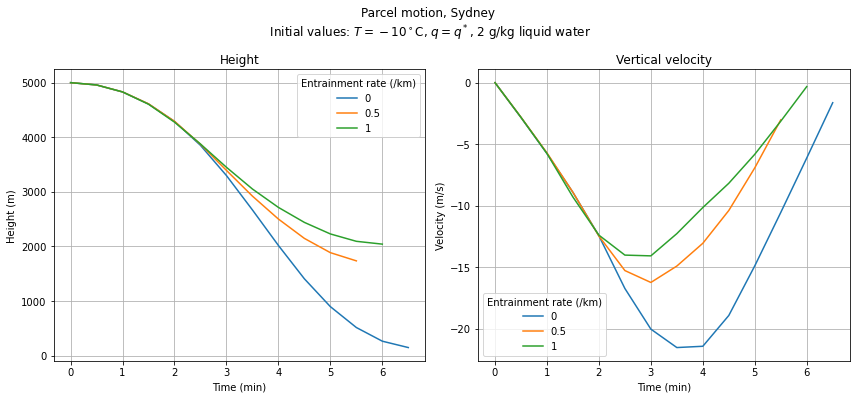

In [38]:
fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(121)
ax.plot(time.m_as(units.minute), result0.height, label='0')
ax.plot(time.m_as(units.minute), result1.height, label='0.5')
ax.plot(time.m_as(units.minute), result2.height, label='1')
ax.set(
    xlabel='Time (min)',
    ylabel='Height (m)',
    title='Height')
ax.grid()
lgd = ax.legend()
lgd.set_title('Entrainment rate (/km)')

ax = fig.add_subplot(122)
ax.plot(time.m_as(units.minute), result0.velocity, label='0')
ax.plot(time.m_as(units.minute), result1.velocity, label='0.5')
ax.plot(time.m_as(units.minute), result2.velocity, label='1')
ax.set(
    xlabel='Time (min)',
    ylabel='Velocity (m/s)',
    title='Vertical velocity')
ax.grid()
lgd = ax.legend()
lgd.set_title('Entrainment rate (/km)')

fig.tight_layout()
fig.suptitle(
    'Parcel motion, Sydney\n Initial values: $T = -10^\circ$C, $q=q^*$, '
    '2 g/kg liquid water', y=1.1)
plt.show()

- The entraining parcels descend less because mixing causes them to come into equilibrium with the environment sooner.
- Their maximum velocities are thus lower (and more realistic!).

## Summary of the work up to this point

1. We started by familiarising ourself with MetPy and how to calculate the temperature of a descending parcel as a function of pressure.
2. We then considered three regimes under which an environmental parcel might become negatively buoyant and descend:
    1. The dry regime: precipitation falls into a parcel, evaporating some water but not enough to saturate it. The parcel descends dry adiabatically.
    2. The saturated regime: The parcel is saturated by precipitation and descends moist adiabatically (with an infinite source of liquid water).
    3. The limited regime: The parcel is saturated by precipiation and has a limited amount of liquid water added to it. The parcel descends moist adiabatically until this water evaporates, then dry adiabatically.
3. We compared the motion of parcels under these three regimes, using several different real atmospheric sounding datasets for the environmental density.
4. We came up with a theoretical model for entrainment and began to implement it.
5. The method for finding the temperature of a descending parcel and switching from moist to dry adiabat was inefficient, so we implemented the Bolton's (1980) approximate formula for $\theta_E$ and used conservation of $\theta_E$ to find the correct final temperature.
6. We implemented Davies-Jones' (2008) approximate formula for wet bulb temperature as a function of $\theta_E$, allowing us to find the temperature of a parcel after evaporation/condensation of water when reaching phase equilibrium.
7. Despite the $\theta_E$ and wet-bulb temperature improvements, the entrainment calculation still failed for moist descent; it diverged for small finite difference steps.
8. We resolved this issue by using a simpler method to find the temperature of an entraining parcel as a function of height (descending in many small discrete steps).
9. Knowing the entraining parcel's temperature as a function of height, we implemented a function to solve its equation of motion (this notebook).

### Main achievements/results
- Determine the motion of an air parcel (with or without entrainment) given the appropriate initial conditions
- Improve on the calculation of wet-bulb temperature

## Code structure

- $\verb|environment.py|$ defines the $\verb|Environment|$ class, which allows calculation of environmental variables as a function of height/pressure, given a sounding dataset.
- $\verb|thermo.py|$ defines useful thermodynamic calculations:
    - The Davies-Jones wet bulb approximation
    - The Bolton $\theta_E$ approximation
    - Descent of a parcel with liquid water and moist to dry adiabat switching
    - Auxiliary functions for entrainment
- $\verb|parcel.py|$ contains the old functions relating to parcel buoyancy and motion under the three regimes. It groups them into a single class called $\verb|Parcel|$.
- $\verb|entraining_parcel.py|$ will contain the functions for buoyancy and motion of an entraining parcel, grouped into the $\verb|EntrainingParcel|$ class.

The general workflow is:
1. Create an instance of $\verb|Environment|$ using a sounding dataset
2. Create an instance of $\verb|EntrainingParcel|$ to correspond to the environment
3. Perform calculations using the methods contained in the classes.

## Next steps

- Examine motion for different initial conditions, soundings, entrainment rates, etc. and draw conclusions relating to original questions about factors that affect downdrafts
- Implement reversible adiabats (how much of a difference to they make?)